**Data Preprocessing (Client Data)**

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(csv_file):
    dataset = pd.read_csv(csv_file)
    dataset = dataset[['cycle', 'capacity', 'Voltage_measured', 'Current_measured', 'Current_load']]
    dataset = dataset.groupby('cycle', as_index=False).mean()
    unique_cycles = sorted(dataset['cycle'].unique())
    cycle_map = {old: new for new, old in enumerate(unique_cycles)}
    dataset['cycle'] = dataset['cycle'].map(cycle_map)

    data_train = dataset[dataset['cycle'] < 130].reset_index(drop=True)
    data_test = dataset[dataset['cycle'] >= 130].reset_index(drop=True)

    sc = MinMaxScaler(feature_range=(0, 1))
    features_train = data_train[['capacity', 'Voltage_measured', 'Current_measured', 'Current_load']].values
    features_test = data_test[['capacity', 'Voltage_measured', 'Current_measured', 'Current_load']].values
    scaled_features_train = sc.fit_transform(features_train)
    scaled_features_test = sc.transform(features_test)

    sequence_length = 10
    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_features_train)):
        X_train.append(scaled_features_train[i-sequence_length:i, :])
        y_train.append(scaled_features_train[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    X_test, y_test = [], []
    for i in range(sequence_length, len(scaled_features_test)):
        X_test.append(scaled_features_test[i-sequence_length:i, :])
        y_test.append(scaled_features_test[i, 0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    return X_train, y_train, sc, X_test, y_test

csv_files = ['/content/battery1.csv', '/content/battery2.csv', '/content/battery3.csv']

X_train_all = []
y_train_all = []
X_test_all = []
y_test_all = []

for file in csv_files:
    X_train, y_train, sc, X_test, y_test = preprocess_data(file)

    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

    print(f"Processed data for {file} - Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")
    print(f"Processed data for {file} - Test data shape: {y_train.shape}, Test data shape: {y_test.shape}")

Processed data for /content/battery1.csv - Train data shape: (120, 10, 4), Test data shape: (28, 10, 4)
Processed data for /content/battery1.csv - Test data shape: (120,), Test data shape: (28,)
Processed data for /content/battery2.csv - Train data shape: (120, 10, 4), Test data shape: (28, 10, 4)
Processed data for /content/battery2.csv - Test data shape: (120,), Test data shape: (28,)
Processed data for /content/battery3.csv - Train data shape: (120, 10, 4), Test data shape: (28, 10, 4)
Processed data for /content/battery3.csv - Test data shape: (120,), Test data shape: (28,)


**Data Preprocessing (Global Data)**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_single_battery(csv_file):

    df = pd.read_csv(csv_file)

    df = df[['cycle', 'capacity', 'Voltage_measured', 'Current_measured', 'Current_load']]
    df = df.groupby('cycle', as_index=False).mean()

    cycle_mapping = {old: new for new, old in enumerate(sorted(df['cycle'].unique()))}
    df['cycle'] = df['cycle'].map(cycle_mapping)

    scaler = MinMaxScaler(feature_range=(0, 1))
    features = df[['capacity', 'Voltage_measured', 'Current_measured', 'Current_load']].values
    scaled_features = scaler.fit_transform(features)

    sequence_length = 10
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i, :])
        y.append(scaled_features[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    return X, y, scaler

csv_file = '/content/battery4.csv'

X_data, y_data, data_scaler = preprocess_single_battery(csv_file)

print(f"Processed data - X shape: {X_data.shape}, y shape: {y_data.shape}")


Processed data - X shape: (122, 10, 4), y shape: (122,)


**Model Architecture and Training Clients**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=200, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

local_models = []

for i in range(len(csv_files)):
    print(f"Training local model for client {i+1}")
    X_train = X_train_all[i]
    y_train = y_train_all[i]

    local_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    local_model.fit(X_train, y_train, epochs=400, batch_size=25)
    local_models.append(local_model)

Training local model for client 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2792
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0628
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0413
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0192
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111
Epoch 7/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062
Epoch 8/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 
Epoch 9/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058
Epoch 10/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053
Epoch 11/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 
Epoch 12/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038
Epoch 13/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 14/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052
Epoch 15/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032
Epoch 16/400
5/5 ━

**Knowledge Distillation**

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.losses import KLDivergence, MeanSquaredError


def compute_distillation_loss(global_model, client_model, X, y, temperature=10, alpha=0.1):
    client_pred = client_model(X, training=False)
    global_pred = global_model(X, training=True)

    student_loss = MeanSquaredError()(y, global_pred)
    distillation_loss = KLDivergence()(
        tf.nn.softmax(client_pred / temperature),
        tf.nn.softmax(global_pred / temperature)
    ) * (temperature ** 2)

    return alpha * student_loss + (1 - alpha) * distillation_loss

**Training Global Model**

In [5]:
def train_global_model(global_model, client_models, X_global, y_global, epochs, temperature=10, alpha=0.1):
    optimizer = Adam()

    for epoch in range(epochs):
        for client_model in client_models:
            with tf.GradientTape() as tape:
                loss = compute_distillation_loss(global_model, client_model, X_global, y_global, temperature, alpha)
            gradients = tape.gradient(loss, global_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, global_model.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")


input_shape = (X_data.shape[1], X_data.shape[2])
global_model = create_lstm_model(input_shape)

train_global_model(global_model, local_models, X_data, y_data, epochs=35, temperature=10, alpha=0.1)

Epoch 1/35, Loss: 0.0031696369405835867
Epoch 2/35, Loss: 0.0015125528443604708
Epoch 3/35, Loss: 0.002822734182700515
Epoch 4/35, Loss: 0.0022998866625130177
Epoch 5/35, Loss: 0.000688005646225065
Epoch 6/35, Loss: 0.001720689469948411
Epoch 7/35, Loss: 0.0007027657120488584
Epoch 8/35, Loss: 0.0012670885771512985
Epoch 9/35, Loss: 0.0006083053885959089
Epoch 10/35, Loss: 0.0009409328340552747
Epoch 11/35, Loss: 0.0006802821881137788
Epoch 12/35, Loss: 0.0007854247814975679
Epoch 13/35, Loss: 0.0006228885613381863
Epoch 14/35, Loss: 0.0006577607127837837
Epoch 15/35, Loss: 0.0005673777195625007
Epoch 16/35, Loss: 0.0007063578232191503
Epoch 17/35, Loss: 0.0005870979512110353
Epoch 18/35, Loss: 0.0006229105638340116
Epoch 19/35, Loss: 0.000673338829074055
Epoch 20/35, Loss: 0.0005109722842462361
Epoch 21/35, Loss: 0.0006163750658743083
Epoch 22/35, Loss: 0.000562878034543246
Epoch 23/35, Loss: 0.0005242079496383667
Epoch 24/35, Loss: 0.0006279225926846266
Epoch 25/35, Loss: 0.000555803

**Evalutaion on Train data**

In [48]:
def evaluate_global_model(global_model, X_test_all, y_test_all):
    total_mse = 0
    for i in range(len(X_test_all)):
        print(f"Evaluating global model on train data of client {i+1}")

        mse = global_model.evaluate(X_test_all[i], y_test_all[i], verbose=0)
        print(f"Client {i+1} - MSE: {mse}")
        total_mse += mse

    average_mse = total_mse / len(X_test_all)
    print(f"Average MSE across all clients: {average_mse}")

evaluate_global_model(global_model, X_train_all, y_train_all)


Evaluating global model on train data of client 1
Client 1 - MSE: 0.01969168893992901
Evaluating global model on train data of client 2
Client 2 - MSE: 0.010673441924154758
Evaluating global model on train data of client 3
Client 3 - MSE: 0.02524304948747158
Average MSE across all clients: 0.018536060117185116


In [49]:
import matplotlib.pyplot as plt
import numpy as np

predicted_test_all = []
y_test = []

for i in range(3):
    X_test_client = X_train_all[i]
    y_test_client = y_train_all[i]

    predicted_test = global_model.predict(X_test_client)

    predicted_test = predicted_test.reshape(-1, 1)
    y_test_client = y_test_client.reshape(-1, 1)

    predicted_test = sc.inverse_transform(np.concatenate((predicted_test, np.zeros((predicted_test.shape[0], 3))), axis=1))[:, 0]
    y_test_original = sc.inverse_transform(np.concatenate((y_test_client, np.zeros((y_test_client.shape[0], 3))), axis=1))[:, 0]

    predicted_test_all.append(predicted_test)
    y_test.append(y_test_original)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


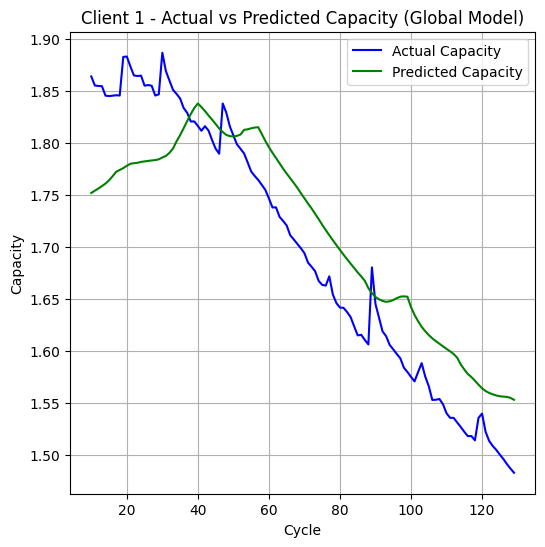

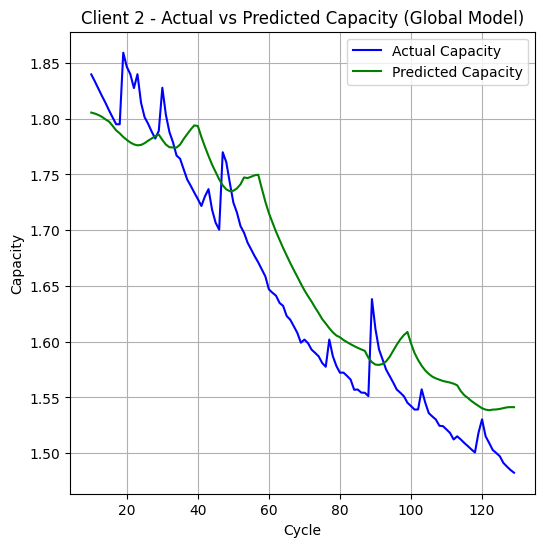

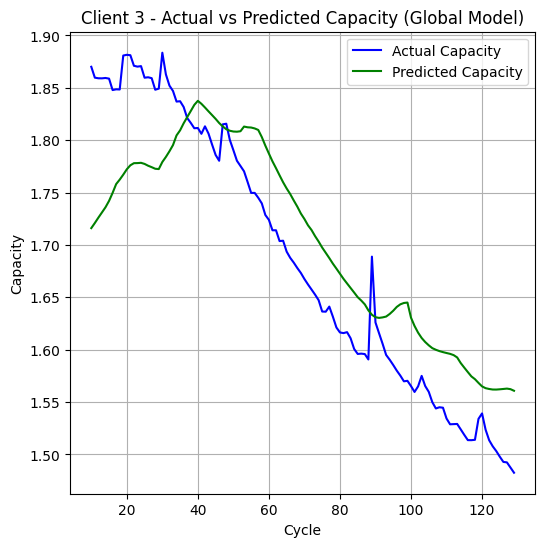

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

csv_files = ['/content/battery1.csv', '/content/battery2.csv', '/content/battery3.csv']
data_test_all = []

for file in csv_files:
    dataset = pd.read_csv(file)
    dataset = dataset[['cycle', 'capacity', 'Voltage_measured', 'Current_measured', 'Current_load']]
    dataset = dataset.groupby('cycle', as_index=False).mean()

    unique_cycles = sorted(dataset['cycle'].unique())
    cycle_map = {old: new for new, old in enumerate(unique_cycles)}
    dataset['cycle'] = dataset['cycle'].map(cycle_map)

    data_test = dataset[dataset['cycle'] < 130].reset_index(drop=True)

    data_test_all.append(data_test)

for i in range(3):
    plt.figure(figsize=(6, 6))

    y_test_original = y_test[i]
    predicted_test = predicted_test_all[i]

    data_test_client = data_test_all[i]
    test_cycle_values = data_test_client['cycle'].values[10:]

    plt.plot(test_cycle_values, y_test_original, color='blue', label='Actual Capacity')
    plt.plot(test_cycle_values, predicted_test, color='green', label='Predicted Capacity')

    plt.xlabel('Cycle')
    plt.ylabel('Capacity')
    plt.title(f'Client {i+1} - Actual vs Predicted Capacity (Global Model)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [52]:
import matplotlib.pyplot as plt
import numpy as np

initial_capacities = [y_test[0][0], y_test[1][0], y_test[2][0]]

original_SoH_all = []
predicted_SoH_all = []

for i in range(3):
    original_SoH = (y_test[i] / initial_capacities[i]) * 100
    predicted_SoH = (predicted_test_all[i] / initial_capacities[i]) * 100
    original_SoH_all.append(original_SoH)
    predicted_SoH_all.append(predicted_SoH)
    accuracy = 100 - (np.mean(np.abs((original_SoH - predicted_SoH) / original_SoH)) * 100)
    print(f"\nBattery {i + 1}:")
    print(f"Original SoH (First 10 values): {original_SoH[:10]}")
    print(f"Predicted SoH (First 10 values): {predicted_SoH[:10]}")
    print(f"Accuracy: {accuracy:.2f}%")


Battery 1:
Original SoH (First 10 values): [100.          99.53025979  99.50997887  99.49592554  99.0070275
  98.98488318  99.00619319  99.02823425  99.01512678 101.0103277 ]
Predicted SoH (First 10 values): [93.97907432 94.0974989  94.21069378 94.33481958 94.46571761 94.63254961
 94.84512585 95.07346696 95.16763429 95.26445695]
Accuracy: 96.90%

Battery 2:
Original SoH (First 10 values): [100.          99.66248777  99.3056275   98.95127252  98.61455145
  98.24533486  97.90558339  97.57242642  97.57303437 101.05862627]
Predicted SoH (First 10 values): [98.14055749 98.09316457 98.02436032 97.93348032 97.80884674 97.70199527
 97.496333   97.27419232 97.12979526 96.95235273]
Accuracy: 97.66%

Battery 3:
Original SoH (First 10 values): [100.          99.44427301  99.41340514  99.40986521  99.4287846
  99.39527129  98.81142127  98.84928135  98.84145588 100.57412034]
Predicted SoH (First 10 values): [91.76396191 92.02513103 92.30062044 92.5638195  92.82899511 93.15402356
 93.56327071 94.012

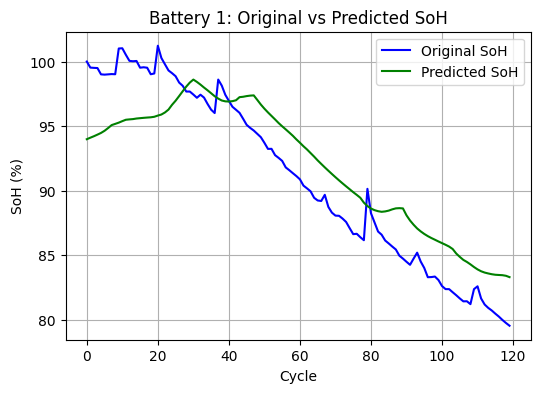

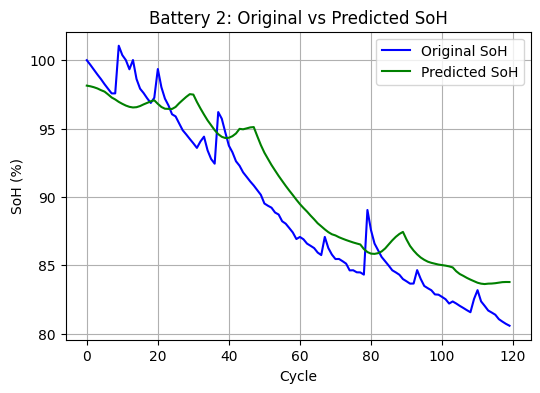

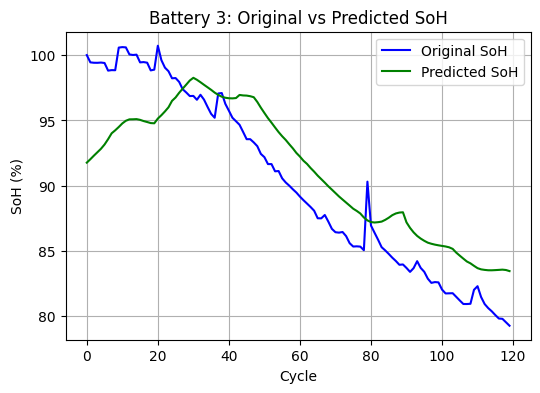

In [53]:
for i in range(3):
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(original_SoH_all[i])), original_SoH_all[i], label="Original SoH", color='blue')
    plt.plot(range(len(predicted_SoH_all[i])), predicted_SoH_all[i], label="Predicted SoH", color='green')
    plt.title(f'Battery {i + 1}: Original vs Predicted SoH')
    plt.xlabel('Cycle')
    plt.ylabel('SoH (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Evalutaion on Test data**

In [54]:
def evaluate_global_model(global_model, X_test_all, y_test_all):
    total_mse = 0
    for i in range(len(X_test_all)):
        print(f"Evaluating global model on test data of client {i+1}")

        mse = global_model.evaluate(X_test_all[i], y_test_all[i], verbose=0)
        print(f"Client {i+1} - MSE: {mse}")
        total_mse += mse

    average_mse = total_mse / len(X_test_all)
    print(f"Average MSE across all clients: {average_mse}")

evaluate_global_model(global_model, X_test_all, y_test_all)

Evaluating global model on test data of client 1
Client 1 - MSE: 0.016486098989844322
Evaluating global model on test data of client 2
Client 2 - MSE: 0.02697933092713356
Evaluating global model on test data of client 3
Client 3 - MSE: 0.019978241994976997
Average MSE across all clients: 0.021147890637318294


In [55]:
import matplotlib.pyplot as plt
import numpy as np

predicted_test_all = []
y = []

for i in range(3):
    X_test_client = X_test_all[i]
    y_test_client = y_test_all[i]
    predicted_test = global_model.predict(X_test_client)
    predicted_test = predicted_test.reshape(-1, 1)
    y_test_client = y_test_client.reshape(-1, 1)
    predicted_test = sc.inverse_transform(np.concatenate((predicted_test, np.zeros((predicted_test.shape[0], 3))), axis=1))[:, 0]
    y_test_original = sc.inverse_transform(np.concatenate((y_test_client, np.zeros((y_test_client.shape[0], 3))), axis=1))[:, 0]
    predicted_test_all.append(predicted_test)
    y.append(y_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


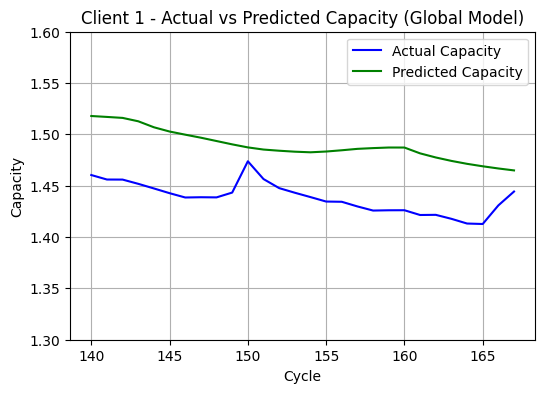

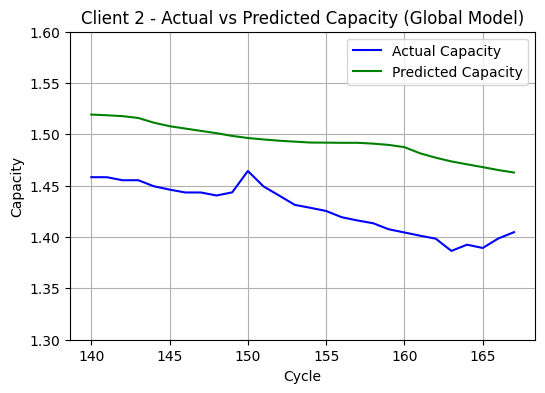

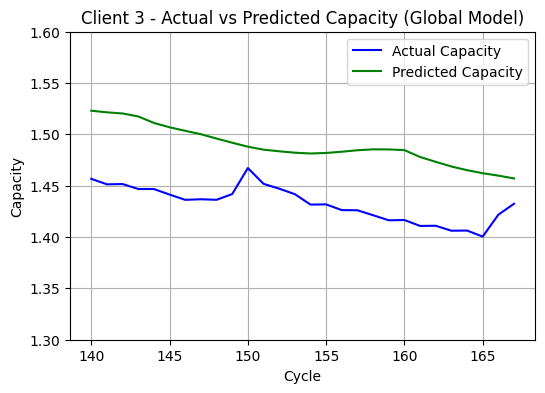

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

csv_files = ['/content/battery1.csv', '/content/battery2.csv', '/content/battery3.csv']
data_test_all = []

for file in csv_files:
    dataset = pd.read_csv(file)
    dataset = dataset[['cycle', 'capacity', 'Voltage_measured', 'Current_measured', 'Current_load']]
    dataset = dataset.groupby('cycle', as_index=False).mean()

    unique_cycles = sorted(dataset['cycle'].unique())
    cycle_map = {old: new for new, old in enumerate(unique_cycles)}
    dataset['cycle'] = dataset['cycle'].map(cycle_map)

    data_test = dataset[dataset['cycle'] >= 130].reset_index(drop=True)

    data_test_all.append(data_test)

for i in range(3):
    plt.figure(figsize=(6, 4))

    y_test_original = y[i]
    predicted_test = predicted_test_all[i]

    data_test_client = data_test_all[i]
    test_cycle_values = data_test_client['cycle'].values[10:]

    plt.plot(test_cycle_values, y_test_original, color='blue', label='Actual Capacity')
    plt.plot(test_cycle_values, predicted_test, color='green', label='Predicted Capacity')

    plt.xlabel('Cycle')
    plt.ylabel('Capacity')
    plt.title(f'Client {i+1} - Actual vs Predicted Capacity (Global Model)')
    plt.legend()
    plt.grid(True)
    plt.ylim(1.3,1.6)
    plt.show()


In [58]:
import matplotlib.pyplot as plt
import numpy as np

initial_capacities = [y_test[0][0], y_test[1][0], y_test[2][0]]

original_SoH_all = []
predicted_SoH_all = []

for i in range(3):
    original_SoH = (y[i] / initial_capacities[i]) * 100
    predicted_SoH = (predicted_test_all[i] / initial_capacities[i]) * 100
    original_SoH_all.append(original_SoH)
    predicted_SoH_all.append(predicted_SoH)
    accuracy = 100 - (np.mean(np.abs((original_SoH - predicted_SoH) / original_SoH)) * 100)
    print(f"\nBattery {i + 1}:")
    print(f"Original SoH (First 10 values): {original_SoH[:10]}")
    print(f"Predicted SoH (First 10 values): {predicted_SoH[:10]}")
    print(f"Accuracy: {accuracy:.2f}%")


Battery 1:
Original SoH (First 10 values): [78.33694017 78.10256578 78.09910027 77.8778008  77.63601209 77.38920537
 77.16367216 77.17707701 77.16925808 77.4208377 ]
Predicted SoH (First 10 values): [81.42085455 81.37293873 81.32205278 81.14547843 80.83216688 80.61028617
 80.44611931 80.28758688 80.11370249 79.93962299]
Accuracy: 96.46%

Battery 2:
Original SoH (First 10 values): [79.26930819 79.26790072 79.107024   79.10984364 78.78742638 78.61237806
 78.46063401 78.45974634 78.29971648 78.466096  ]
Predicted SoH (First 10 values): [82.58476668 82.54726956 82.50135308 82.40528172 82.15445706 81.96946392
 81.84473621 81.72033822 81.60054575 81.45517852]
Accuracy: 95.36%

Battery 3:
Original SoH (First 10 values): [77.8962998  77.61072932 77.62468372 77.36801637 77.36485749 77.07730746
 76.80276193 76.83323127 76.80537627 77.10285678]
Predicted SoH (First 10 values): [81.44418114 81.36099044 81.3015253  81.1467824  80.80866998 80.58229821
 80.39848663 80.22109937 79.99549502 79.7782657

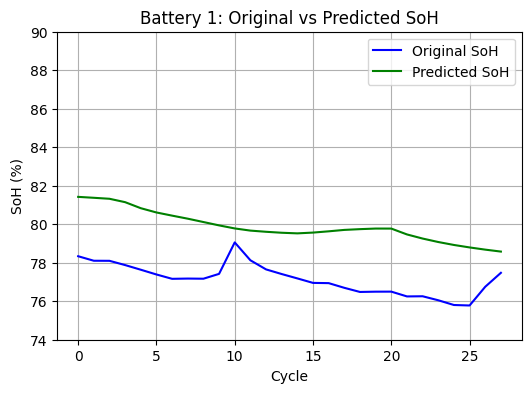

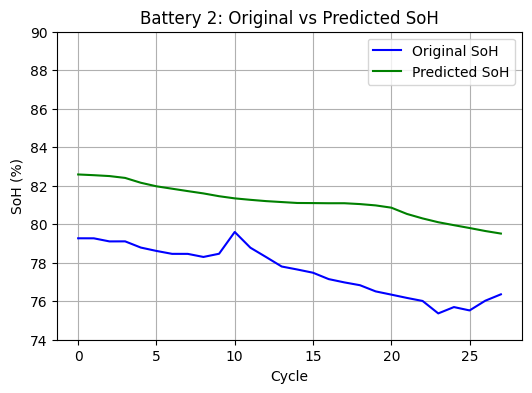

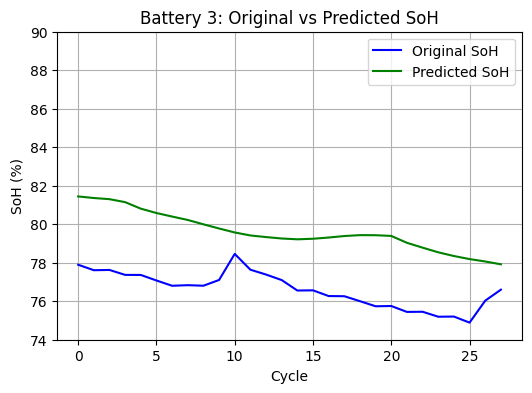

In [59]:
for i in range(3):
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(original_SoH_all[i])), original_SoH_all[i], label="Original SoH", color='blue')
    plt.plot(range(len(predicted_SoH_all[i])), predicted_SoH_all[i], label="Predicted SoH", color='green')
    plt.title(f'Battery {i + 1}: Original vs Predicted SoH')
    plt.xlabel('Cycle')
    plt.ylabel('SoH (%)')
    plt.legend()
    plt.ylim(74,90)
    plt.grid(True)
    plt.show()